In [1]:
import re
import os
import json
import warnings
from selenium import webdriver
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
# import rasterio as rio
# import solaris as sol
# import earthpy.spatial as es
# from shapely.geometry import Polygon
# from rasterio.mask import raster_geometry_mask

from utilits.text_preprocessor import clean_text, drop_short_words
from utilits.parser import parser_phone
plt.style.use('seaborn-poster')
warnings.filterwarnings('ignore')

In [2]:
DIR_DATA = 'data'
NAME_JSON = 'phones_center_rus.json'
NAME_DF = 'phones_df.csv'
NAME_DF_CLEAN = 'phones_df_clean.csv'
NAME_SHP = 'data/Regions/Regions.shp'
mode_parser = False
mode_clean = False

In [3]:
if mode_parser:
    parser_phone(DIR_DATA, NAME_JSON, NAME_DF)

In [4]:
if mode_clean:
    # Load parser's data
    df = pd.read_csv(os.path.join(DIR_DATA, NAME_DF))

    # Clean prices
    df.prices = df.prices.str.replace('₽','')
    df.prices = df.prices.str.replace(' ','')
    df.loc[df.prices.str.contains('Бесплатно'), 'prices'] = 0
    df.prices[df.prices == 'Ценанеуказана'] = None
    df = df.dropna()
    df.prices = df.prices.astype('int')
    df = df[df.prices > 1000]

    # Clean phones
    df['phones'] = clean_text(df['phones'])
    df['phones'] = df['phones'].str.replace('^| .*$', '')
    df['phones'] = df['phones'].apply(drop_short_words)
    df = df[df['phones'] != '']
    df.loc[(df['phones'] == 'apple') | (df['phones'] == 'se'), 'phones'] = 'iphone'
    df.loc[(df['phones'] == 'xaomi'), 'phones'] = 'xiaomi'
    df.loc[(df['phones'] == 'honor'), 'phones'] = 'huawei'
    rare_phones = df.phones.value_counts()[df.phones.value_counts() < 10].index
    df = df[~df.phones.isin(rare_phones)]

    # Save clean df
    df.to_csv(os.path.join(DIR_DATA, NAME_DF_CLEAN), index=False)

In [5]:
df = pd.read_csv(os.path.join(DIR_DATA, NAME_DF_CLEAN))

In [6]:
# Select subsets: Moscow, Centers of Regions, Villages
region_centers = df.city.value_counts()[0:16].index.tolist()
df_region = df[df.city.isin(region_centers)]
df_moskva = df[df.region == 'moskva']
df_villages = df[df.region != 'moskva']
df_villages = df_villages[~df_villages.city.isin(region_centers)]

In [7]:
top_villages = round(df_villages.phones.value_counts()[0:10]/df_villages.phones.value_counts().sum()*100, 1)
top_villages = top_villages.sort_values()
top_villages

lenovo      1.3
asus        1.4
nokia       1.6
bq          2.8
meizu       3.3
zte         4.0
xiaomi      8.8
samsung    11.2
huawei     15.1
iphone     39.1
Name: phones, dtype: float64

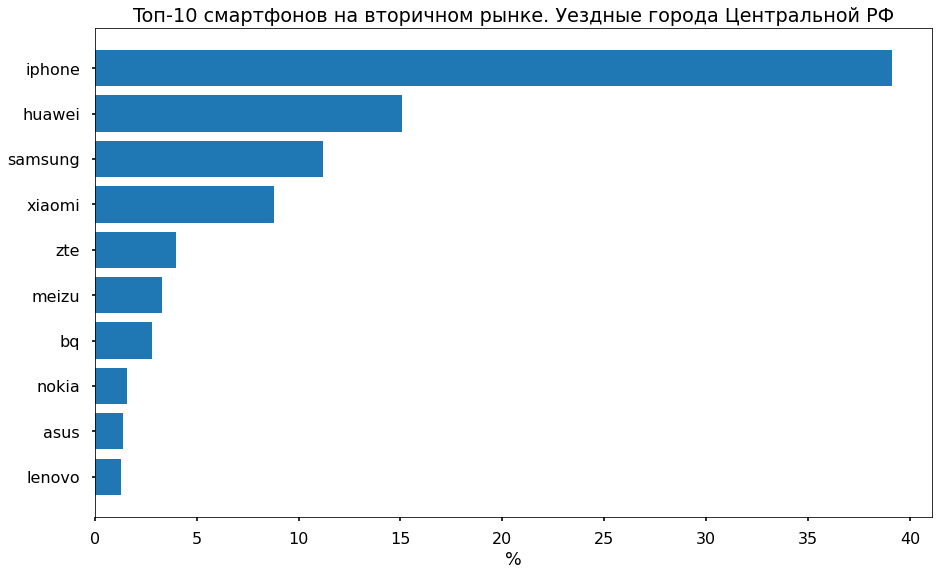

In [8]:
plt.figure(figsize=(15, 9))
plt.title('Toп-10 смартфонов на вторичном рынке. Уездные города Центральной РФ')
plt.xlabel('%')
plt.barh(top_villages.index, top_villages.values)
plt.show()

In [92]:
df_region.phones.value_counts()[0:3]/df_region.phones.value_counts().sum()*100

iphone     50.466576
samsung    16.368346
huawei     11.118122
Name: phones, dtype: float64

In [93]:
df_moskva.phones.value_counts()[0:3]/df_moskva.phones.value_counts().sum()*100

iphone     60.202429
samsung    14.696356
huawei      8.380567
Name: phones, dtype: float64

In [169]:
df[(df.phones == 'iphone')].groupby('region')['prices'].median().sort_values()

region
lipetskaya_oblast        6990.0
bryanskaya_oblast        7500.0
ryazanskaya_oblast       8700.0
kurskaya_oblast          9500.0
yaroslavskaya_oblast    10000.0
vladimirskaya_oblast    10000.0
smolenskaya_oblast      10000.0
tverskaya_oblast        11999.5
orlovskaya_oblast       12000.0
tambovskaya_oblast      13000.0
ivanovskaya_oblast      13500.0
kaluzhskaya_oblast      13500.0
voronezhskaya_oblast    13500.0
kostromskaya_oblast     14000.0
belgorodskaya_oblast    15000.0
moskovskaya_oblast      17500.0
tulskaya_oblast         24000.0
moskva                  33000.0
Name: prices, dtype: float64

In [162]:
# Load geo shapes
df_geo = pd.DataFrame(df[(df.phones == 'iphone')].groupby('region')['prices'].median().sort_values().reset_index())

geo_shapes = gpd.read_file(NAME_SHP)
geo_shapes = geo_shapes[geo_shapes.ADM3_NAME == 'Центральный федеральный округ']

df_geo.region = [
    'Липецкая область',
    'Брянская область',
    'Рязанская область',
    'Курская область',
    'Ярославская область',
    'Владимирская область',
    'Смоленская область',
    'Тверская область',
    'Орловская область',
    'Тамбовская область',
    'Ивановская область',
    'Калужская область',
    'Воронежская область',
    'Костромская область',
    'Белгородская область',
    'Московская область',
    'Тульская область',
    'Москва']

df_geo = df_geo.sort_values('region')
geo_shapes = geo_shapes.sort_values('NAME')

geo_shapes['prices'] = df_geo['prices'].values

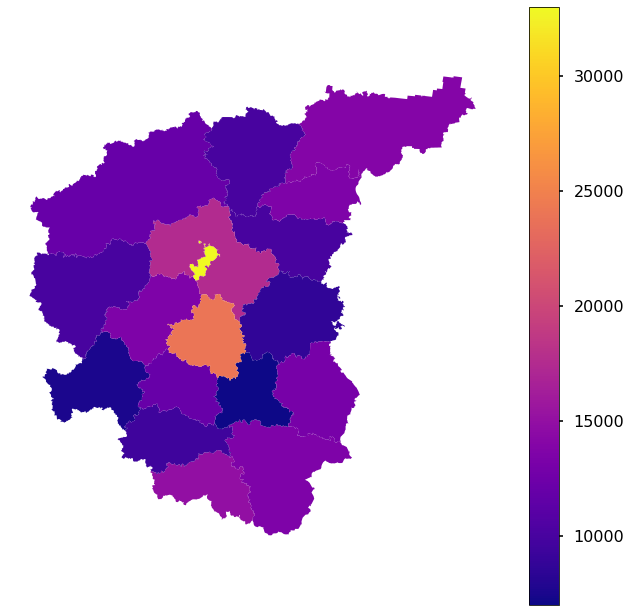

In [168]:
geo_shapes.plot(column = 'prices', linewidth=0, cmap='plasma', legend=True, figsize=[11,11]).set_axis_off()